<a href="https://colab.research.google.com/github/hackcheek/rented-bike-prediction/blob/main/datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import xgboost as xgb
import torch.nn as nn
import torch

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


**Extract data**

In [ ]:
!git clone https://@github.com/hackcheek/rented-bike-prediction.git

Cloning into 'rented-bike-prediction'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 130 (delta 8), reused 33 (delta 5), pack-reused 89
Receiving objects: 100% (130/130), 32.71 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (37/37), done.


# Preprocessing

In [ ]:
E_data_train = pd.read_excel('rented-bike-prediction/bike_train.xlsx')
E_data_test = pd.read_excel('rented-bike-prediction/bike_test.xlsx')

In [ ]:
E_data_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dy
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,11995,2012-05-19,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,71,168,239,19
11995,11996,2012-05-20,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,42,128,170,20
11996,11997,2012-05-20,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,28,102,130,20
11997,11998,2012-05-20,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,36,62,98,20


In [ ]:
def preprocessing(data=lambda x: x.copy(), n_components=None, no_consider=list()) -> pd.DataFrame:
    
    data['dy'] = data.dteday.dt.day

    _features = {
       'yr', 
       'mnth', 
       'dy',
       'hr', 
       'weekday',
       'temp', 
       'atemp', 
       'hum', 
       'windspeed',
    }
    _categorical = {
       'season', 
       'holiday', 
       'workingday', 
       'weathersit', 
        
    }
    features = list(_features.difference(no_consider))
    categorical = list(_categorical.difference(no_consider))

    # Get standarscaler 

    if n_components == 'no':
        data[list(_features)] = StandardScaler().fit_transform(data[list(_features)])
        data = data.astype({k:'int' for k in _categorical})
        all_feat = list(_features) + ['cnt'] if 'cnt' in data.columns else list(_features)
        return data[all_feat + list(_categorical)]
    else:
        # X = StandardScaler().fit_transform(data[features])
        X = MinMaxScaler().fit_transform(data[features])
        data = data.astype({k:'int' for k in _categorical})
        X = pd.concat(X, data, axis=1)
        

    if no_consider:
        data[no_consider] = StandardScaler().fit_transform(data[no_consider])


    # Data reductor with PCA
    components = n_components if n_components else int(len(features) / 2)
    pca = PCA(n_components=components)
    principal_components = pca.fit_transform(X)

    df = pd.DataFrame(
        principal_components,
        columns=[f'component {i}' for i in range(1, components+1)]
    )
    for i in no_consider:
        df[i] = data[i]

    # Add cnt for training data
    if 'cnt' in data.columns:
        df['cnt'] = data['cnt']

    return df


# data_train = preprocessing(E_data_train, no_consider=['hr', 'temp', 'atemp', 'hum'])
# data_test = preprocessing(E_data_test, no_consider=['hr', 'temp', 'atemp', 'hum'])

data_train = preprocessing(E_data_train, n_components='no')
data_test = preprocessing(E_data_test, n_components='no')

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   hr          11999 non-null  float64 
 1   mnth        11999 non-null  float64 
 2   dy          11999 non-null  float64 
 3   atemp       11999 non-null  float64 
 4   yr          11999 non-null  float64 
 5   windspeed   11999 non-null  float64 
 6   hum         11999 non-null  float64 
 7   weekday     11999 non-null  float64 
 8   temp        11999 non-null  float64 
 9   cnt         11999 non-null  int64   
 10  season      11999 non-null  category
 11  workingday  11999 non-null  category
 12  holiday     11999 non-null  category
 13  weathersit  11999 non-null  category
dtypes: category(4), float64(9), int64(1)
memory usage: 985.1 KB


# Utils

In [ ]:
def deploy(model):
    model.fit(data_train.drop('cnt', axis=1), data_train['cnt'])
    pred = model.predict(data_test)
    pred = np.array(pred).tolist()
    print(pred)
    
    pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv', index=False)

In [ ]:
# Divide metrics for scoring
def rmse(y_test, pred):
    return mean_squared_error(y_test, pred, squared=False)
    

def r2(y_test, pred):
    return r2_score(y_test, pred)


def grid_scorer():
    return make_scorer(r2, greater_is_better=True)


def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    RMSE = rmse(y_test, predictions)
    R2 = r2(y_test, predictions)
    print('Model Performance')
    print(f'RMSE: {RMSE}')
    print(f'R2: {R2}')

# Deep learning

## Tran test split and get features and target on torch

In [ ]:
X = data_train.drop('cnt', axis=1).to_numpy()
y = data_train['cnt'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = torch.from_numpy(X_train)
target = torch.from_numpy(y_train)

NameError: ignored

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

# Random Forest

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train

### testing depths

In [ ]:
# testing depths -> 17
for d in range(1, 21):
    RF = RandomForestRegressor(n_estimators=100, max_depth=d, random_state=42, criterion='mse')
    RF.fit(features, target)
    print(f'\nDEPTH {d}\n')
    evaluate(RF, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 1

Model Performance
RMSE: 127.35527165428084
R2: 0.3066730100753333


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 2

Model Performance
RMSE: 116.58320102443848
R2: 0.41899990308182733


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 3

Model Performance
RMSE: 109.602568975904
R2: 0.4864937650878651


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 4

Model Performance
RMSE: 99.82747470575232
R2: 0.5740050763642921


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 5

Model Performance
RMSE: 90.61121038133363
R2: 0.6490315181060577


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 6

Model Performance
RMSE: 80.15119641618878
R2: 0.7253849892214456


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 7

Model Performance
RMSE: 66.73703226048298
R2: 0.8096126741941274


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 8

Model Performance
RMSE: 55.96474157079862
R2: 0.8661145881107593


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 9

Model Performance
RMSE: 49.211526138709615
R2: 0.896476744526575


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 10

Model Performance
RMSE: 44.74076902824292
R2: 0.9144320469175038


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 11

Model Performance
RMSE: 41.534511934682
R2: 0.9262567155529364


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 12

Model Performance
RMSE: 39.68975074732837
R2: 0.9326618785221638


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 13

Model Performance
RMSE: 38.5725754615348
R2: 0.9363993537751486


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 14

Model Performance
RMSE: 37.98784286219396
R2: 0.9383130185298749


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 15

Model Performance
RMSE: 37.761366877973984
R2: 0.9390463570803332


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 16

Model Performance
RMSE: 37.496546550789716
R2: 0.9398982945988247


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 17

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 18

Model Performance
RMSE: 37.5898049306822
R2: 0.9395989626161823


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 19

Model Performance
RMSE: 37.72262919286955
R2: 0.9391713521265725


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



DEPTH 20

Model Performance
RMSE: 37.68553876894466
R2: 0.9392909117230445


### Testing estimators

In [ ]:
# testing estimators -> 600
for n in np.arange(100, 1001, 100): 
    RF = RandomForestRegressor(n_estimators=n, max_depth=17, random_state=42, criterion='mse')
    RF.fit(features, target)
    print(f'\nESTIMATORS {n}\n')
    evaluate(RF, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 100

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 200

Model Performance
RMSE: 37.31330884285308
R2: 0.9404842680228137


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 300

Model Performance
RMSE: 37.23386814870298
R2: 0.9407374183458806


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 400

Model Performance
RMSE: 37.11899540395016
R2: 0.9411025243299117


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 500

Model Performance
RMSE: 37.038098988185595
R2: 0.9413589646077298


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 600

Model Performance
RMSE: 37.008299691314235
R2: 0.9414532868706509


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 700

Model Performance
RMSE: 37.02488090200559
R2: 0.9414008125409982


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 800

Model Performance
RMSE: 37.01664434103828
R2: 0.9414268816103668


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 900

Model Performance
RMSE: 37.0209181489984
R2: 0.9414133555484996


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



ESTIMATORS 1000

Model Performance
RMSE: 37.056431039065984
R2: 0.9413009013424591


### Min leaf

In [ ]:
# testing min_samples_leaf -> 1
for l in np.arange(1, 10, 1): 
    RF = RandomForestRegressor(
        n_estimators=100, 
        max_depth=17, 
        min_samples_leaf=l,
        random_state=42, 
        criterion='mse'
    )
    RF.fit(features, target)
    print(f'\nMIN LEAF {l}\n')
    evaluate(RF, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 1

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 2

Model Performance
RMSE: 37.98390069280931
R2: 0.9383258209368289


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 3

Model Performance
RMSE: 38.61736458643734
R2: 0.9362515663323397


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 4

Model Performance
RMSE: 39.65982096508599
R2: 0.9327633987065305


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 5

Model Performance
RMSE: 40.60461338571866
R2: 0.9295217660134533


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 6

Model Performance
RMSE: 41.451836107488866
R2: 0.9265500002855224


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 7

Model Performance
RMSE: 42.449062332710746
R2: 0.9229734481820501


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 8

Model Performance
RMSE: 43.36652672170715
R2: 0.9196078701993899


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN LEAF 9

Model Performance
RMSE: 44.356180910242884
R2: 0.9158967950506827


### min_samples_split

In [ ]:
# testing min_samples_leaf -> 1
for s in np.arange(2, 20, 1): 
    RF = RandomForestRegressor(
        n_estimators=100, 
        max_depth=17, 
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=42, 
        criterion='mse'
    )
    RF.fit(features, target)
    print(f'\nMIN SPLIT {s}\n')
    evaluate(RF, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 2

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 3

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 4

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 5

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 6

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 7

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 8

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 9

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 10

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 11

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 12

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 13

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 14

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 15

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 16

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 17

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 18

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



MIN SPLIT 19

Model Performance
RMSE: 37.47877361749996
R2: 0.9399552561350482


### Max features

In [ ]:
# testing max_features -> 10
for f in np.arange(1, len(features), 1): 
    RF = RandomForestRegressor(
        n_estimators=600, 
        max_depth=17, 
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=f,
        random_state=42, 
    )
    RF.fit(features, target)
    print(f'\nMAX FEATURES {f}\n')
    evaluate(RF, X_test, y_test)


MAX FEATURES 1

Model Performance
RMSE: 73.68381677442765
R2: 0.7679142468591567

MAX FEATURES 2

Model Performance
RMSE: 64.16421980758679
R2: 0.8240091497250878

MAX FEATURES 3

Model Performance
RMSE: 55.43321667803399
R2: 0.8686456635710457

MAX FEATURES 4

Model Performance
RMSE: 47.96358368345373
R2: 0.9016606115630048

MAX FEATURES 5

Model Performance
RMSE: 42.96657512924211
R2: 0.9210838792786424

MAX FEATURES 6

Model Performance
RMSE: 39.62733570242659
R2: 0.93287350026848

MAX FEATURES 7

Model Performance
RMSE: 38.036286846503145
R2: 0.9381555856044075

MAX FEATURES 8

Model Performance
RMSE: 37.01631017467806
R2: 0.9414279391388262

MAX FEATURES 9

Model Performance
RMSE: 36.651282210439625
R2: 0.9425774335563684

MAX FEATURES 10

Model Performance
RMSE: 36.510118231620325
R2: 0.9430189126625063

MAX FEATURES 11

Model Performance
RMSE: 36.73438943826602
R2: 0.942316725577341

MAX FEATURES 12

Model Performance
RMSE: 36.66643710962849
R2: 0.9425299365484047

MAX FEATURES

ValueError: ignored

### Rest of code

In [ ]:
RF_best = RandomForestRegressor(
    n_estimators=600, 
    max_depth=17, 
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42, 
)

RFR = RandomForestRegressor()

params_search = dict(
    n_estimators = [100, 300, 600],
    max_depth = [6, 8, 10, 12, 15, 20],

)
rand_search = RandomizedSearchCV(
    estimator=RFR,
    param_distributions=params_search,
    scoring='neg_mean_squared_error',
    n_iter=25,
    verbose=2
)

rand_search.fit(features, target)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 18 is smaller than n_iter=25. Running 18 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.7s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   4.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   4.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   4.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   4.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   4.5s
[CV] END ......................max_depth=6, n_estimators=600; total time=   9.0s
[CV] END ......................max_depth=6, n_es

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=25,
                   param_distributions={'max_depth': [6, 8, 10, 12, 15, 20],
                                        'n_estimators': [100, 300, 600]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_RFR = rand_search.best_estimator_
evaluate(best_RFR, X_test, y_test)
best_RFR

Model Performance
RMSE: 38.941286749076944
R2: 0.9361592184671619


RandomForestRegressor(max_depth=20, n_estimators=600)

In [ ]:
pred = best_RFR.predict(data_test)
pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv', index=False)

In [ ]:
deploy(RF_best)

In [ ]:
RF_best.feature_importances_

array([0.01506727, 0.05730237, 0.0355855 , 0.07404715, 0.57812095,
       0.01948687, 0.09747497, 0.01772358, 0.0147447 , 0.01998987,
       0.05582443, 0.01149127, 0.00314107])

In [ ]:
_X = E_data_train['temp']
_y = E_data_train.iloc[:, -1]
_X

0        0.24
1        0.22
2        0.22
3        0.24
4        0.24
         ... 
11994    0.60
11995    0.58
11996    0.56
11997    0.56
11998    0.54
Name: temp, Length: 11999, dtype: float64

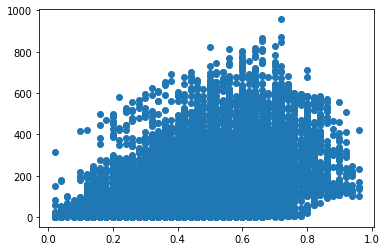

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(_X, _y)

# Gradient Boosting

In [ ]:
X = data_train.drop(['cnt'], axis=1)
y = data_train['cnt']

pred_to_column = model.predict(X)
pred_to_column_test = model.predict(data_test)

X['pred'] = pred_to_column
data_test['pred'] = pred_to_column_test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
GB = GradientBoostingRegressor()

param_grid = dict(
    n_estimators = [100],
    subsample = [0.9, 0.5, 0.2, 0.1],
    max_depth = [4,6,8,10],
    learning_rate = [0.1,0.2,0.3,0.4],
)

grid_GB = GridSearchCV(
    estimator=GB, 
    param_grid=param_grid, 
    cv=3,
)

In [ ]:
grid_GB.fit(features, target)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [4, 6, 8, 10], 'n_estimators': [100],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [ ]:
best_GB = grid_GB.best_estimator_

evaluate(best_GB, X_test, y_test)
deploy(best_GB)

Model Performance
Average Error: 21.6660 degrees.
Accuracy = 66.14%.
RMSE: 36.29157242781587


In [ ]:
print("BEST ESTIMATOR:\n", grid_GB.best_estimator_, end='\n\n')
print("BEST PARAMS:\n", grid_GB.best_params_, end='\n\n')
print("BEST SCORE:\n", grid_GB.best_score_, end='\n\n')

BEST ESTIMATOR:
 GradientBoostingRegressor(max_depth=8, subsample=0.9)

BEST PARAMS:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.9}

BEST SCORE:
 0.9398196096897333



## Learning rate

In [ ]:
for lr in np.arange(0.01, 1, 0.01):
    GBR = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=lr
    )
    GBR.fit(features, target)
    print(f'\n\nLEARNING RATE {lr}')
    evaluate(GBR, X_test, y_test)




LEARNING RATE 0.01
Model Performance
RMSE: 110.5964898815338
R2: 0.4651055203731881


LEARNING RATE 0.02
Model Performance
RMSE: 92.89738489262541
R2: 0.6226082466464107


LEARNING RATE 0.03
Model Performance
RMSE: 84.76343541064115
R2: 0.6858026419543246


LEARNING RATE 0.04
Model Performance
RMSE: 80.12248068504114
R2: 0.7192665240931171


LEARNING RATE 0.05
Model Performance
RMSE: 73.50545056870276
R2: 0.7637213304089332


LEARNING RATE 0.060000000000000005
Model Performance
RMSE: 69.73655743023755
R2: 0.7873298988252788


LEARNING RATE 0.06999999999999999
Model Performance
RMSE: 66.32430994889073
R2: 0.8076328507309622


LEARNING RATE 0.08
Model Performance
RMSE: 64.9658491672048
R2: 0.8154323138432207


LEARNING RATE 0.09
Model Performance
RMSE: 61.93560382771957
R2: 0.832248589406845


LEARNING RATE 0.09999999999999999
Model Performance
RMSE: 62.60032161931637
R2: 0.8286285159405258


LEARNING RATE 0.11
Model Performance
RMSE: 60.00234370023726
R2: 0.842557543444487


LEARNING 

## Estimators

In [ ]:
# 300 o 500 
for e in np.arange(100, 2001, 100):
    GBR = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.53,
    )
    GBR.fit(features, target)
    print(f'\n\nESTIMATORS {e}')
    evaluate(GBR, X_test, y_test)



ESTIMATORS 100
Model Performance
RMSE: 44.43186759646548
R2: 0.9136674507160883


ESTIMATORS 200
Model Performance
RMSE: 44.431867596465494
R2: 0.9136674507160882


ESTIMATORS 300
Model Performance
RMSE: 44.41982731431776
R2: 0.913714233688266


ESTIMATORS 400
Model Performance
RMSE: 44.44671549652151
R2: 0.9136097411795203


ESTIMATORS 500
Model Performance
RMSE: 44.41069887379966
R2: 0.9137496941391494


ESTIMATORS 600
Model Performance
RMSE: 44.42555384886266
R2: 0.9136919846025814


ESTIMATORS 700
Model Performance
RMSE: 44.43759257941665
R2: 0.9136452016304037


ESTIMATORS 800
Model Performance
RMSE: 44.43467923764834
R2: 0.913656524151698


ESTIMATORS 900
Model Performance
RMSE: 44.51831287074086
R2: 0.9133311920244239


ESTIMATORS 1000
Model Performance
RMSE: 44.44671549652155
R2: 0.9136097411795202


ESTIMATORS 1100
Model Performance
RMSE: 44.43759257941665
R2: 0.9136452016304037


ESTIMATORS 1200
Model Performance
RMSE: 44.41982731431776
R2: 0.913714233688266


ESTIMATORS 13

## depth

In [ ]:
# 11
for d in np.arange(1, 20, 1):
    GBR = GradientBoostingRegressor(
        n_estimators = 100,
        learning_rate = 0.53,
        max_depth = d,
    )
    GBR.fit(features, target)
    print(f'\n\nESTIMATORS {d}')
    evaluate(GBR, X_test, y_test)



ESTIMATORS 1
Model Performance
RMSE: 85.85706391700081
R2: 0.6776427114632508


ESTIMATORS 2
Model Performance
RMSE: 64.64146667330012
R2: 0.8172708507556417


ESTIMATORS 3
Model Performance
RMSE: 44.44671549652152
R2: 0.9136097411795203


ESTIMATORS 4
Model Performance
RMSE: 40.22038384052809
R2: 0.9292579158335943


ESTIMATORS 5
Model Performance
RMSE: 37.091519753449276
R2: 0.9398362795168378


ESTIMATORS 6
Model Performance
RMSE: 38.16030461513264
R2: 0.9363191144114622


ESTIMATORS 7
Model Performance
RMSE: 41.228111238576965
R2: 0.9256686009540684


ESTIMATORS 8
Model Performance
RMSE: 39.23849472960263
R2: 0.9326697687757984


ESTIMATORS 9
Model Performance
RMSE: 39.68507792125342
R2: 0.9311284426555663


ESTIMATORS 10
Model Performance
RMSE: 38.734390318367815
R2: 0.934388664495979


ESTIMATORS 11
Model Performance
RMSE: 37.38558359848023
R2: 0.9388785346400342


ESTIMATORS 12
Model Performance
RMSE: 40.21185490723904
R2: 0.9292879150771025


ESTIMATORS 13
Model Performance
R

## subsample

In [ ]:
# 1
for s in np.arange(0.1, 3, 0.1):
    GBR = GradientBoostingRegressor(
        n_estimators = 100,
        learning_rate = 0.53,
        max_depth = 11,
        subsample = s,
    )
    GBR.fit(features, target)
    print(f'\n\nSUBSAMPLE {s}')
    evaluate(GBR, X_test, y_test)



SUBSAMPLE 0.1
Model Performance
RMSE: 1194.9934732945933
R2: -61.44770686784764


SUBSAMPLE 0.2
Model Performance
RMSE: 196.2480546827782
R2: -0.6842096433971574


SUBSAMPLE 0.30000000000000004
Model Performance
RMSE: 89.20818167870056
R2: 0.6519875320710989


SUBSAMPLE 0.4
Model Performance
RMSE: 61.14417346302155
R2: 0.836508346543982


SUBSAMPLE 0.5
Model Performance
RMSE: 51.531162883813096
R2: 0.8838751101647058


SUBSAMPLE 0.6
Model Performance
RMSE: 46.9670228725313
R2: 0.9035346169696014


SUBSAMPLE 0.7000000000000001
Model Performance
RMSE: 44.266178207365805
R2: 0.9143101298163272


SUBSAMPLE 0.8
Model Performance
RMSE: 44.39800467268667
R2: 0.9137989940726444


SUBSAMPLE 0.9
Model Performance
RMSE: 42.446771667785484
R2: 0.921209336265521


SUBSAMPLE 1.0
Model Performance
RMSE: 38.23515039404617
R2: 0.9360690682090657


ValueError: ignored

## Code

In [ ]:
GBR = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate = 0.3,
    max_depth = 11,
    subsample = 1,
)
GBR.fit(features, target)
evaluate(GBR, X_test, y_test)

Model Performance
RMSE: 38.666960729240536
R2: 0.9360499999213429


In [ ]:
predict = GBR.predict(data_test.drop(['yr', 'mnth'], axis=1))
pd.DataFrame({'pred': predict}).to_csv('hackcheek.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- atemp
- pred
Feature names must be in the same order as they were in fit.




ValueError: ignored

In [ ]:
XGB = xgb.XGBRegressor(objective='reg:squarederror')
XGB.fit(features, target)

XGBRegressor(objective='reg:squarederror')

In [ ]:
evaluate(XGB, X_test, y_test)
deploy(XGB)

Model Performance
RMSE: 58.70651607529522
R2: 0.844985763771593


In [ ]:
params = dict( 
    max_depth = [3, 5, 6, 10, 15, 20],
    learning_rate = [0.01, 0.1, 0.2, 0.3],
    subsample = np.arange(0.5, 1.0, 0.1),
    colsample_bytree = np.arange(0.4, 1.0, 0.1),
    colsample_bylevel = np.arange(0.4, 1.0, 0.1),
    n_estimators = [100, 500, 1000],
)

XGB = xgb.XGBRegressor(seed = 20)
rand_search = RandomizedSearchCV(
    estimator=XGB,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    n_iter=25,
    verbose=1
)
rand_search.fit(features, target)
print("Best parameters:", rand_search.best_params_)
print("Lowest RMSE: ", (-rand_search.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[18:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:22] WARNING: /workspace/src/objective/regr

In [ ]:
best_rand = rand_search.best_estimator_
evaluate(best_rand, X_test, y_test)
deploy(best_rand)

Model Performance
RMSE: 32.095880491626126
R2: 0.9536662386673325
[19:01:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
evaluate(best_rand, X_test, y_test)

Model Performance
RMSE: 11.820909503641223
R2: 0.9938993899170137


In [ ]:
XGBR = xgb.XGBRegressor(
    colsample_bylevel=0.7999999999999999,
    colsample_bytree=0.8999999999999999, learning_rate=0.01,
    max_depth=10, n_estimators=1000, seed=20, subsample=0.6
)

XGBR.fit(features, target)
pred = XGBR.predict(data_test)
evaluate(XGBR, X_test, y_test)

pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv', index=False)

[00:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Performance
RMSE: 32.97248667688851
R2: 0.9542299905643185


In [ ]:
pred = best_rand.predict(data_test)
pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv')

# Polynomic regression

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train

In [ ]:
# define the pipeline and train model
for d in np.arange(1, 10):
    PF = Pipeline(
        [('poly', PolynomialFeatures(
            degree=d
        )),
        ('linear', LinearRegression(fit_intercept=False))]
    )
                    
    PF.fit(features, target)
    print('\nDEGREE', d)
    evaluate(PF, X_test, y_test)


DEGREE 1
Model Performance
RMSE: 121.6011331047428
R2: 0.3818610101142593

DEGREE 2
Model Performance
RMSE: 103.26164261256065
R2: 0.5542524621751386

DEGREE 3
Model Performance
RMSE: 92.08348166610831
R2: 0.6455341851297312

DEGREE 4
Model Performance
RMSE: 2543.784644761751
R2: -269.50268320627305


In [ ]:
PF = Pipeline(
    [('poly', PolynomialFeatures(
        degree=3
    )),
    ('linear', LinearRegression(fit_intercept=False))]
)

PF.fit(features, target)
evaluate(PF, X_test, y_test)


Model Performance
RMSE: 91.52420330327331
R2: 0.6258814175401735


In [ ]:
poly_pred = PF.predict(data_train.drop('cnt', axis=1))

DATA = data_train
DATA['poly'] = poly_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Model Performance
RMSE: 90.17831582965549
R2: 0.6451628158350551


# Gaussian regressor

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
                                              
# Determination of the kernel used and the value lenght_scale at which the optimization process starts
kernel = 1.0 * RBF(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e3)
)

# Application of the regressor (alpha makes a statement about a possible noise of the training data)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
gp.fit(features, target)

# Prediction of the dependent variable for the test dataset
pred, sigma = gp.predict(X_test, return_std=True)
evaluate(gp, X_test, y_test)

In [ ]:
import sklearn.gaussian_process as gp
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
GPR = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

GPR.fit(features, target)
params = GPR.kernel_.get_params()

# evaluate(GPR, X_test, y_test)

# Deep learning

## torch

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(13, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ) 

    def forward(self, x):
        return self.layers(x)


class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)    

    def __len__(self):
        return len(self.X)  

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [ ]:
X = data_train.drop('cnt', axis=1).to_numpy()
y = data_train.cnt.to_numpy()

data = TorchDataset(X, y, scale_data=False)
data_torch = torch.utils.data.DataLoader(data, batch_size=1100, shuffle=True, num_workers=1)

NameError: ignored

In [ ]:
torch.manual_seed(42)

# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
  
  print(f'Starting epoch {epoch+1}')
  current_loss = 0.0
  
  for i, data in enumerate(data_torch, 0):


    # Get and prepare inputs
    features, target = data
    features, target = features.float(), target.float()
    target = target.reshape((target.shape[0], 1))
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Perform forward pass
    outputs = mlp(features)
    
    # Compute loss
    loss = loss_function(outputs, target)
    
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()
    
    # Print statistics
    current_loss += loss.item()
    if i % 20 == 0:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / 500))
        current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 108.997
Starting epoch 2
Loss after mini-batch     1: 98.761
Starting epoch 3
Loss after mini-batch     1: 101.877
Starting epoch 4
Loss after mini-batch     1: 104.201
Starting epoch 5
Loss after mini-batch     1: 93.326
Training process has finished.


In [ ]:
len(outputs)

999

## Tensor flow

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=13 ,activation='relu',input_shape=(13, )))
model.add(tf.keras.layers.Dense(units=13 ,activation='relu'))
model.add(tf.keras.layers.Dense(units=7 ,activation='relu'))
model.add(tf.keras.layers.Dense(units=1 ,activation='linear'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 13)                182       
                                                                 
 dense_32 (Dense)            (None, 13)                182       
                                                                 
 dense_33 (Dense)            (None, 7)                 98        
                                                                 
 dense_34 (Dense)            (None, 1)                 8         
                                                                 
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import multiprocessing
from sklearn.metrics import mean_squared_error
metrics = tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer = "Adam", loss = 'mean_squared_error', metrics = metrics)

# dejar primero
epoch_historial = model.fit(features, target,epochs= 1000, batch_size= 900, shuffle=True, use_multiprocessing=True)
epoch_historial = model.fit(features, target,epochs= 100, batch_size= 100, shuffle=True, use_multiprocessing=True)
# epoch_historial = model.fit(features, target,epochs= 1000, batch_size= 10, shuffle=True, use_multiprocessing=True)
# epoch_historial = model.fit(features, target,epochs= 1000, batch_size= 500, shuffle=True, use_multiprocessing=True)

Epoch 1/1000
11/11 [==============================] - 1s 2ms/step - loss: 3168.5029 - root_mean_squared_error: 56.2895
Epoch 2/1000
11/11 [==============================] - 0s 3ms/step - loss: 3119.7722 - root_mean_squared_error: 55.8549
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 3120.2512 - root_mean_squared_error: 55.8592
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 3119.1497 - root_mean_squared_error: 55.8493
Epoch 5/1000
11/11 [==============================] - 0s 2ms/step - loss: 3111.4421 - root_mean_squared_error: 55.7803
Epoch 6/1000
11/11 [==============================] - 0s 3ms/step - loss: 3107.8840 - root_mean_squared_error: 55.7484
Epoch 7/1000
11/11 [==============================] - 0s 3ms/step - loss: 3106.4036 - root_mean_squared_error: 55.7351
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 3133.6956 - root_mean_squared_error: 55.9794
Epoch 9/1000
11/11 [============================

In [ ]:
epoch_historial.history.keys()

import plotly.express as px
import plotly.graph_objects as go

fig1 = px.line(epoch_historial.history['loss'])
fig2 = px.line(epoch_historial.history['root_mean_squared_error'])

go.Figure(fig1.data + fig2.data)

In [ ]:
evaluate(model, X_test, y_test)

Model Performance
RMSE: 45.98804397710569
R2: 0.902216342791594


In [ ]:
pred = model.predict(data_test)
pred = np.array(pred.tolist()).reshape(1, -1).tolist()
pd.DataFrame({'pred': pred[0]}).to_csv('hackcheek.csv', index=False)

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train


## keras

In [ ]:
X = data_train.drop('cnt', axis=1)
y = data_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features = X_train
target = y_train

In [ ]:
NN_model = tf.keras.Sequential()

# The Input Layer :
NN_model.add(tf.keras.layers.Dense(600, kernel_initializer='normal', input_dim = features.shape[1], activation='tanh'))

# The Hidden Layers :
NN_model.add(tf.keras.layers.Dense(600, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(300, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(300, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(100, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(50, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(tf.keras.layers.Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 600)               8400      
                                                                 
 dense_8 (Dense)             (None, 600)               360600    
                                                                 
 dense_9 (Dense)             (None, 300)               180300    
                                                                 
 dense_10 (Dense)            (None, 300)               90300     
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto'
)
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(features, target, epochs=128, batch_size=256, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/128
30/30 [==============================] - ETA: 0s - loss: 2.7293 - mean_absolute_error: 2.7293
Epoch 1: val_loss did not improve from 20.31076
30/30 [==============================] - 1s 40ms/step - loss: 2.7293 - mean_absolute_error: 2.7293 - val_loss: 20.5325 - val_mean_absolute_error: 20.5325
Epoch 2/128
29/30 [============================>.] - ETA: 0s - loss: 2.1153 - mean_absolute_error: 2.1153
Epoch 2: val_loss did not improve from 20.31076
30/30 [==============================] - 1s 33ms/step - loss: 2.1153 - mean_absolute_error: 2.1153 - val_loss: 20.5679 - val_mean_absolute_error: 20.5679
Epoch 3/128
29/30 [============================>.] - ETA: 0s - loss: 1.9267 - mean_absolute_error: 1.9267
Epoch 3: val_loss did not improve from 20.31076
30/30 [==============================] - 1s 33ms/step - loss: 1.9652 - mean_absolute_error: 1.9652 - val_loss: 20.6541 - val_mean_absolute_error: 20.6541
Epoch 4/128
29/30 [============================>.] - ETA: 0s - loss: 1.7681 

In [ ]:
wights_file = "Weights-095--25.13255.hdf5"
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [ ]:
evaluate(NN_model, X_test, y_test)

Model Performance
RMSE: 34.48306764142209
R2: 0.9480675407323224


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.line(NN_model.history.history['loss'])
fig2 = px.line(NN_model.history.history['root_mean_squared_error'])

go.Figure(fig1.data + fig2.data)

{}


KeyError: ignored

In [ ]:
pred = NN_model.predict(data_test)
pred = pred.reshape(1, -1).tolist()[0]
pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv', index=False)
# pred

## testing

In [ ]:
for i in data_train.columns:
    plt.plot(i.std)

AttributeError: ignored

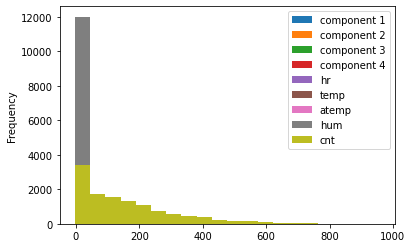

In [ ]:
data_train.plot.hist(stacked=False, bins=20); 

## XGBoost 2

In [ ]:
import xgboost as xgb

train = data_train.copy()

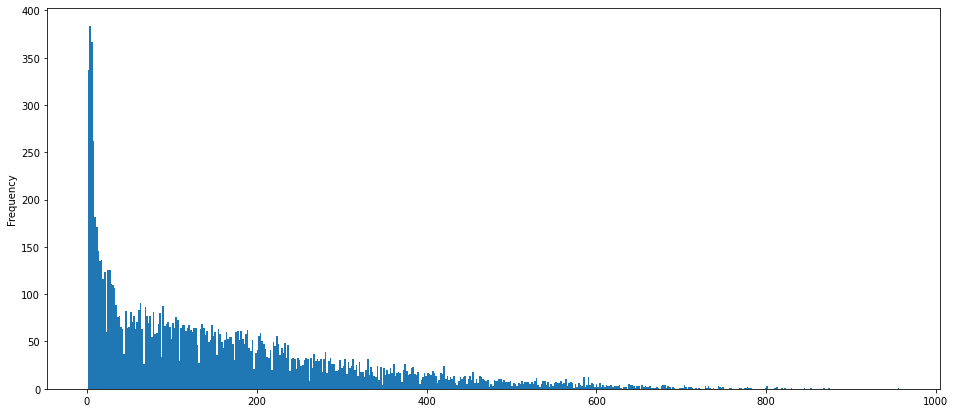

In [ ]:
# filter outliers
train['cnt'].plot.hist(bins=500, figsize=(16, 7)) 

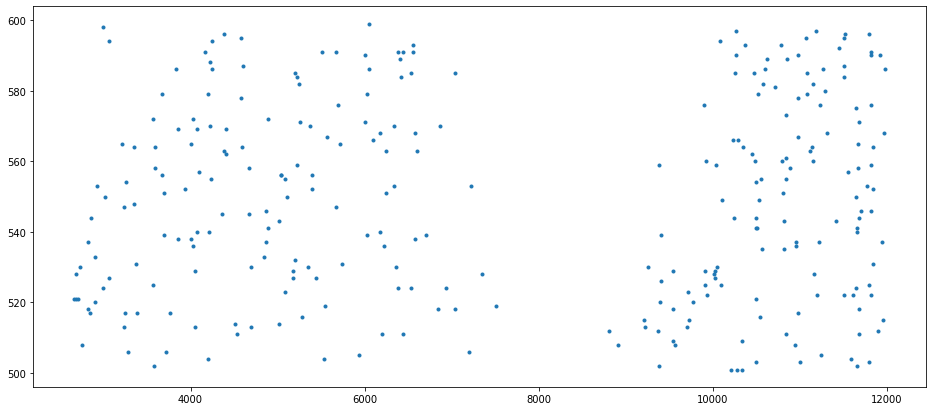

In [ ]:
train.query("cnt > 500")['cnt'].plot(figsize=(16, 7), style='.')

In [ ]:
train = train.query("cnt < 600").copy()

In [ ]:
train


,hr,mnth,dy,atemp,yr,windspeed,hum,weekday,temp,cnt,season,workingday,holiday,weathersit
0,-1.672062,-1.319684,-1.652030,-0.949079,-0.622872,-1.566592,0.918266,1.49147,-1.196932,16,1,0,0,1
1,-1.527378,-1.319684,-1.652030,-1.038688,-0.622872,-1.566592,0.868422,1.49147,-1.302995,40,1,0,0,1
2,-1.382694,-1.319684,-1.652030,-1.038688,-0.622872,-1.566592,0.868422,1.49147,-1.302995,32,1,0,0,1
3,-1.238009,-1.319684,-1.652030,-0.949079,-0.622872,-1.566592,0.619206,1.49147,-1.196932,13,1,0,0,1
4,-1.093325,-1.319684,-1.652030,-0.949079,-0.622872,-1.566592,0.619206,1.49147,-1.196932,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,1.655675,-0.154476,0.406332,1.015838,1.605465,-0.257063,-0.327818,1.49147,0.712188,239,2,0,0,1
11995,-1.672062,-0.154476,0.520685,0.569560,1.605465,-0.733183,-0.477348,-1.50078,0.606125,170,2,0,0,1
11996,-1.527378,-0.154476,0.520685,0.479951,1.605465,-1.566592,-0.527191,-1.50078,0.500063,130,2,0,0,1
11997,-1.382694,-0.154476,0.520685,0.479951,1.605465,-1.566592,-0.527191,-1.50078,0.500063,98,2,0,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1429baedd0>,
      dtype=object)

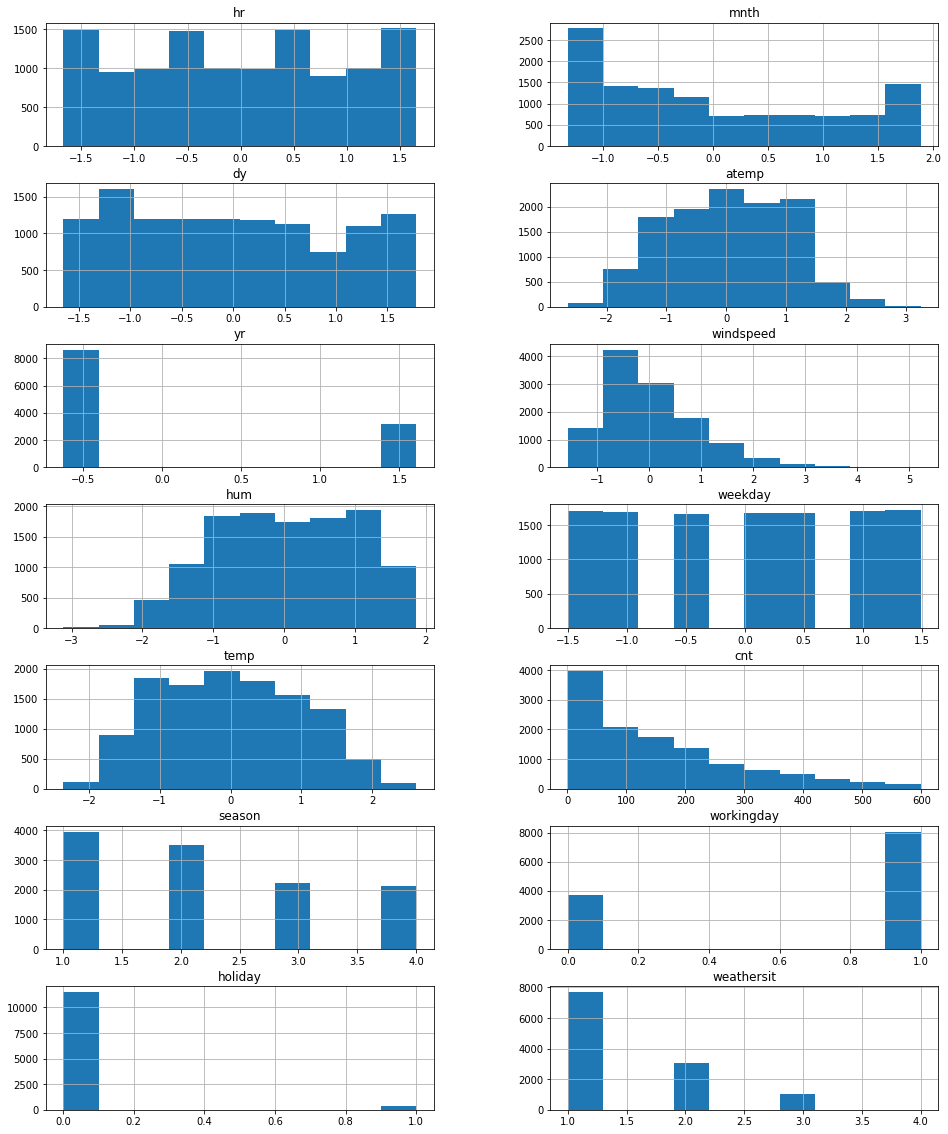

In [ ]:
fig, axis = plt.subplots(7, 2, figsize=(16, 20))
train.hist(ax=axis)

In [ ]:
X = train.drop('cnt', axis=1)
y = train.cnt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
XGBR = xgb.XGBRegressor(
    colsample_bylevel=0.8,
    colsample_bytree=0.9, 
    learning_rate=0.01,
    max_depth=10, 
    n_estimators=1000, 
    seed=20, 
    subsample=0.6
)

XGBR.fit(train.drop('cnt', axis=1), train.cnt)

[06:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.8, colsample_bytree=0.9, learning_rate=0.01,
             max_depth=10, n_estimators=1000, seed=20, subsample=0.6)

In [ ]:
evaluate(XGBR, X_test, y_test)

Model Performance
RMSE: 11.995280237377703
R2: 0.9926393575808716


In [ ]:
pred = XGBR.predict(data_test)
pd.DataFrame({'pred': pred}).to_csv('hackcheek.csv', index=False)

## Deep learning really